In [469]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [470]:
def load_fits(r, galaxy_title, line_name):

    galaxy_file = galaxy_title.replace(' ', '_')

    line_measurement = 0
    addendum = ''

    if line_name == '[OIII]':
        line_measurement = 52
        addendum = 'sw_1'

    if line_name == '[NIII]':
        line_measurement = 57
        addendum = 'sw_2'

    titlename = galaxy_title + ', ' + line_name + ' ' + str(line_measurement) + ' ' + r'$\mu$m, r = {}'.format(str(r))
    filename = galaxy_file + '_' + line_name + '_r={}'.format(str(r))
    
    loaddir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/' + galaxy_file + '_' + addendum + '/'

    savedir = loaddir + 'r=' + str(r) + '/'

    fits_name = galaxy_file + '_' + addendum + '.fits'
    fits_spec_name = galaxy_file + '_' + addendum + '_r={}.fits'.format(str(r))
    
    hdulist = fits.open(loaddir + fits_name)
    hdulist_spec = fits.open(savedir + fits_spec_name)
    
    return hdulist, hdulist_spec, titlename, filename, savedir

In [471]:
def renormalize_spectra(wavelengths, central_fluxes_unfiltered):
    
    central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

    c = 3*10**8

    for i in range(0, len(wavelengths)):

        wavelength = wavelengths[i]

        central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))

    central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)
    
    return central_fluxes_unfiltered

In [472]:
def plot_unfiltered_spectrum(wavelengths, central_fluxes_unfiltered, lower_ind, upper_ind, titlename, filename, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', 
            alpha = 0.3)
    ax.axvspan(wavelengths[0], wavelengths[lower_ind], color = 'red', alpha = 0.1, label = 'Masked Regions')
    ax.axvspan(wavelengths[upper_ind], wavelengths[-1], color = 'red', alpha = 0.1)

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    plt.savefig(savedir + filename + '-1-unfiltered_spectrum.png'.format(str(r)))

    ax.legend(prop={'size': 30}, loc = 'upper right')

In [473]:
def filter_spectra(lower_ind, upper_ind, wavelengths, central_fluxes_unfiltered): 

    wavelengths_filtered = wavelengths[lower_ind:upper_ind+1]
    central_fluxes_filtered = central_fluxes_unfiltered[lower_ind:upper_ind+1]
    
    return wavelengths_filtered, central_fluxes_filtered

In [474]:
def identify_continuum(left_cut, right_cut, wavelengths_filtered, central_fluxes_filtered):
    
    central_fluxes_filtered_continuum = []
    
    for i in range(0, len(wavelengths_filtered)):

        wavelength = wavelengths_filtered[i]

        if(wavelength < left_cut or wavelength > right_cut):
            central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])

        else:
            central_fluxes_filtered_continuum.append(float("Nan"))

    central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

    idcont = np.isfinite(central_fluxes_filtered_continuum)
    cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)
    
    return central_fluxes_filtered_continuum, cont_params

In [475]:
def plot_filtered_spectrum_continuum_points(wavelengths_filtered, central_fluxes_filtered,
                                           central_fluxes_filtered_continuum, titlename, filename, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    ax.legend(prop={'size': 30}, loc = 'upper right')

    plt.savefig(savedir + filename + '-2-filtered_spectrum + continuum_points.png'.format(str(r)))

In [476]:
def plot_filtered_spectrum_continuum_line(wavelengths_filtered, central_fluxes_filtered,
                                    central_fluxes_filtered_continuum, cont_params, titlename, filename, savedir):
    
    cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    ax.legend(prop={'size': 30}, loc = 'upper right')

    plt.savefig(savedir + filename + '-3-filtered_spectrum + continuum_line.png'.format(str(r)))

In [477]:
def subtract_continuum(central_fluxes_filtered_continuum, cont_params, wavelengths_filtered, central_fluxes_filtered):
    
    cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]
    
    id_act = np.isnan(central_fluxes_filtered_continuum)

    wavelengths_act = wavelengths_filtered[id_act]
    central_fluxes_filtered_act = central_fluxes_filtered[id_act]
    cont_line_filtered_act = cont_line_filtered[id_act]

    central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act
    
    return wavelengths_act, central_fluxes_continuum_subtracted_act

In [478]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [479]:
def fit_gaussian(wavelengths_act, central_fluxes_continuum_subtracted_act):
    
    heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

    centers = wavelengths_act

    # Information about the peak in the numerical PDF
    peak_ind = np.where(heights == np.max(heights))[0][0]
    peak_height = np.max(heights)

    # mu is where the numerical PDF peaks
    mu = centers[peak_ind]

    # Estimating sigma using FWHM
    sigma = 0

    for i in range(0, peak_ind):
        if(heights[i] >= peak_height/2):
            sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
            break

    # First fit a Gaussian

    guess_params = np.array([peak_height, sigma])
    fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                               fit_func_1(centers, peak_height, mu, sigma), 
                                               centers, heights, p0=guess_params)

    fit_params = [fit_params[0], mu, fit_params[1]]

    fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)
    
    return(fit_params)

In [480]:
def plot_continuum_subtracted_spectrum(wavelengths_act, central_fluxes_continuum_subtracted_act, titlename, filename, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + filename + '-4-continuum_subtracted_spectrum.png'.format(str(r)))

In [481]:
def overlay(wavelengths_filtered, fit_params):
    
    wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
    cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

    fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered
    
    return wavelength_range, cont_line_filtered, fitted_central_fluxes_act

In [482]:
def plot_fit_continuum_subtracted_spectrum(wavelengths_act, wavelength_range, fit_params, 
                                           central_fluxes_continuum_subtracted_act, titlename, filename, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))
    
    fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)
    
    ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
            label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

    ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
            label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + filename + '-5-fit_continuum_subtracted_spectrum.png'.format(str(r)))

In [483]:
def plot_final_spectrum(wavelengths_filtered, cont_params, fit_params, titlename, filename, savedir):
    
    fig, ax = plt.subplots(figsize = (18, 13))

    wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
    cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

    fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

    ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
    ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
    ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
    ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

    ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
    ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
    ax.set_title(titlename, fontsize = 32)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
    ax.tick_params(labelsize = 38, pad = 10)
    ax.yaxis.offsetText.set_fontsize(36)

    ax.legend(prop={'size': 20}, loc = 'upper right')

    plt.savefig(savedir + filename + '-6-final_spectrum.png'.format(str(r)))

In [484]:
def compute_fluxes(wavelengths_filtered, wavelength_range, cont_line_filtered, central_fluxes_filtered, 
                   fitted_central_fluxes_act):
    
    flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

    flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
    flux_obs_sub = flux_obs - flux_continuum

    flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
    flux_fit_sub = flux_fit - flux_continuum
    
    return flux_continuum, flux_obs_sub, flux_fit_sub

In [485]:
params_dict = {'NGC 2366': {'[OIII]': [25, -27, 51.82, 51.845] , '[NIII]': [] , 
                            '[OH]': [], '[OI]': []}, 
               'NGC 4631': {'[OIII]': [16, -27, 51.845, 51.93] , '[NIII]': [12, -18, 57.415, 57.475] , 
                            '[OH]': [], '[OI]': []}, 
               'NGC 5253': {'[OIII]': [13, -14, 51.835, 51.945] , '[NIII]': [11, -15, 57.35, 57.46] , 
                            '[OH]': [], '[OI]': []}, 
               'NGC 7314': {'[OIII]': [] , '[NIII]': [] , '[OH]': [], '[OI]': []}}

In [486]:
galaxy_title = 'NGC 5253'
line_name = '[OIII]'
r = 13

In [487]:
params = params_dict[galaxy_title][line_name]

lower_ind = params[0]
upper_ind = params[1]
left_cut = params[2]
right_cut = params[3]

In [488]:
hdulist, hdulist_spec, titlename, filename, savedir = load_fits(r, galaxy_title, line_name)

In [489]:
wavelengths = hdulist[5].data
wav_diff = np.average(wavelengths[1:] - wavelengths[:-1])

central_fluxes_unfiltered = hdulist_spec[0].data

In [490]:
central_fluxes_unfiltered = renormalize_spectra(wavelengths, central_fluxes_unfiltered)

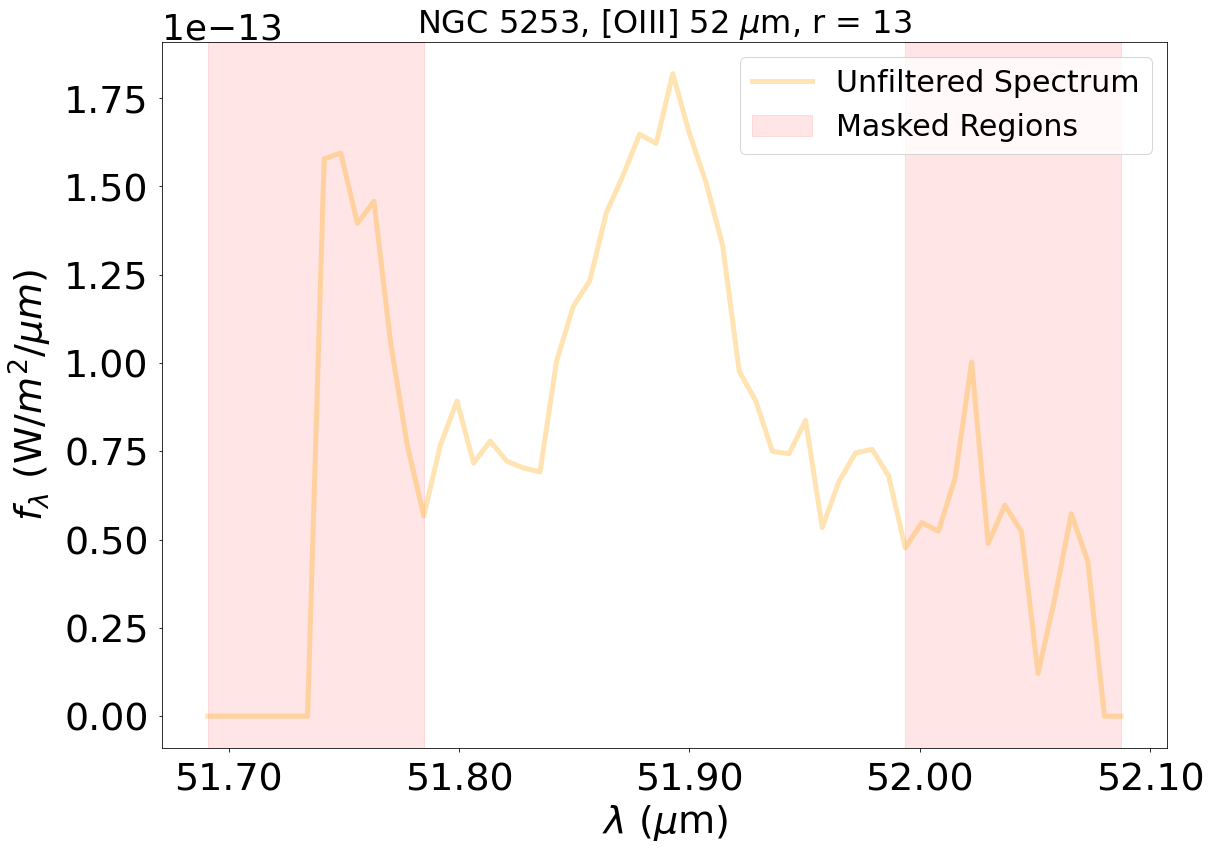

In [491]:
plot_unfiltered_spectrum(wavelengths, central_fluxes_unfiltered, lower_ind, upper_ind, titlename, filename, savedir)

In [492]:
wavelengths_filtered, central_fluxes_filtered = filter_spectra(lower_ind, upper_ind, 
                                                               wavelengths, central_fluxes_unfiltered)

In [493]:
central_fluxes_filtered_continuum, cont_params = identify_continuum(left_cut, right_cut, 
                                                                    wavelengths_filtered, central_fluxes_filtered)

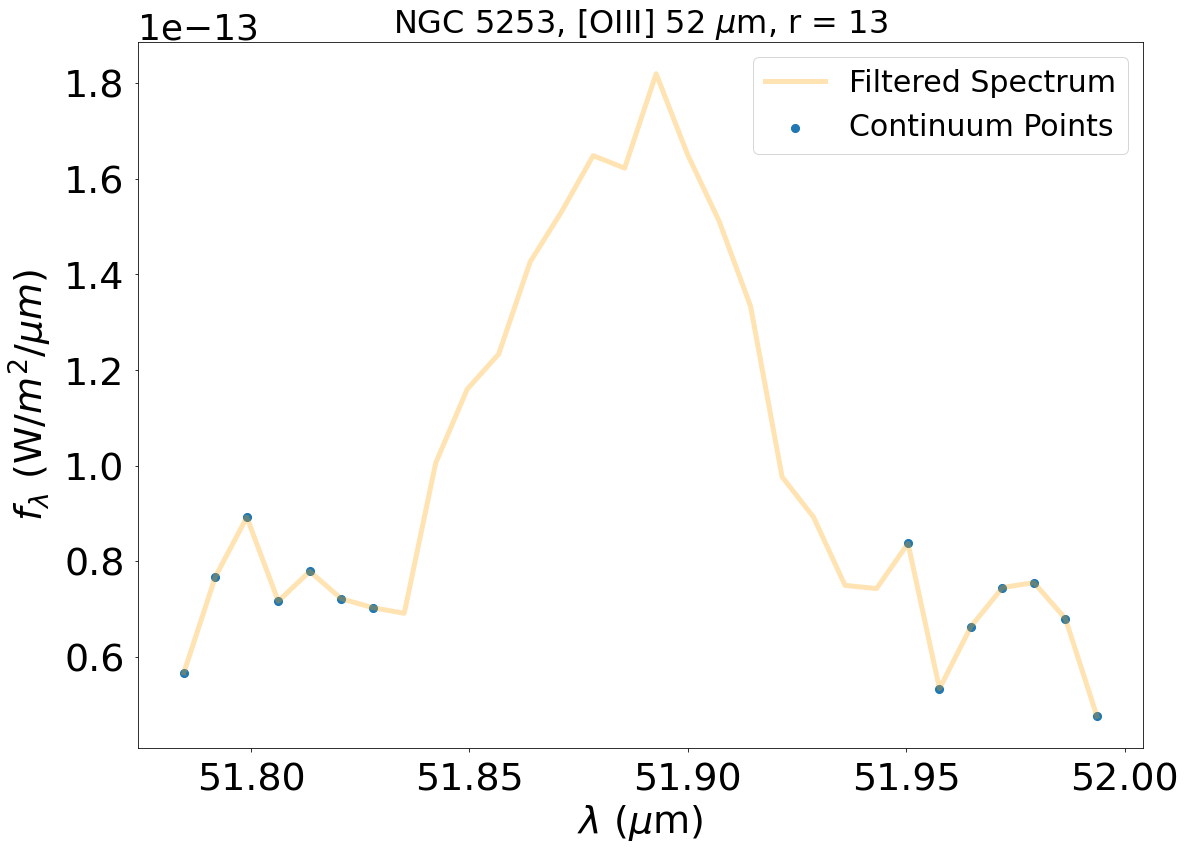

In [494]:
plot_filtered_spectrum_continuum_points(wavelengths_filtered, central_fluxes_filtered,
                                           central_fluxes_filtered_continuum, titlename, filename, savedir)

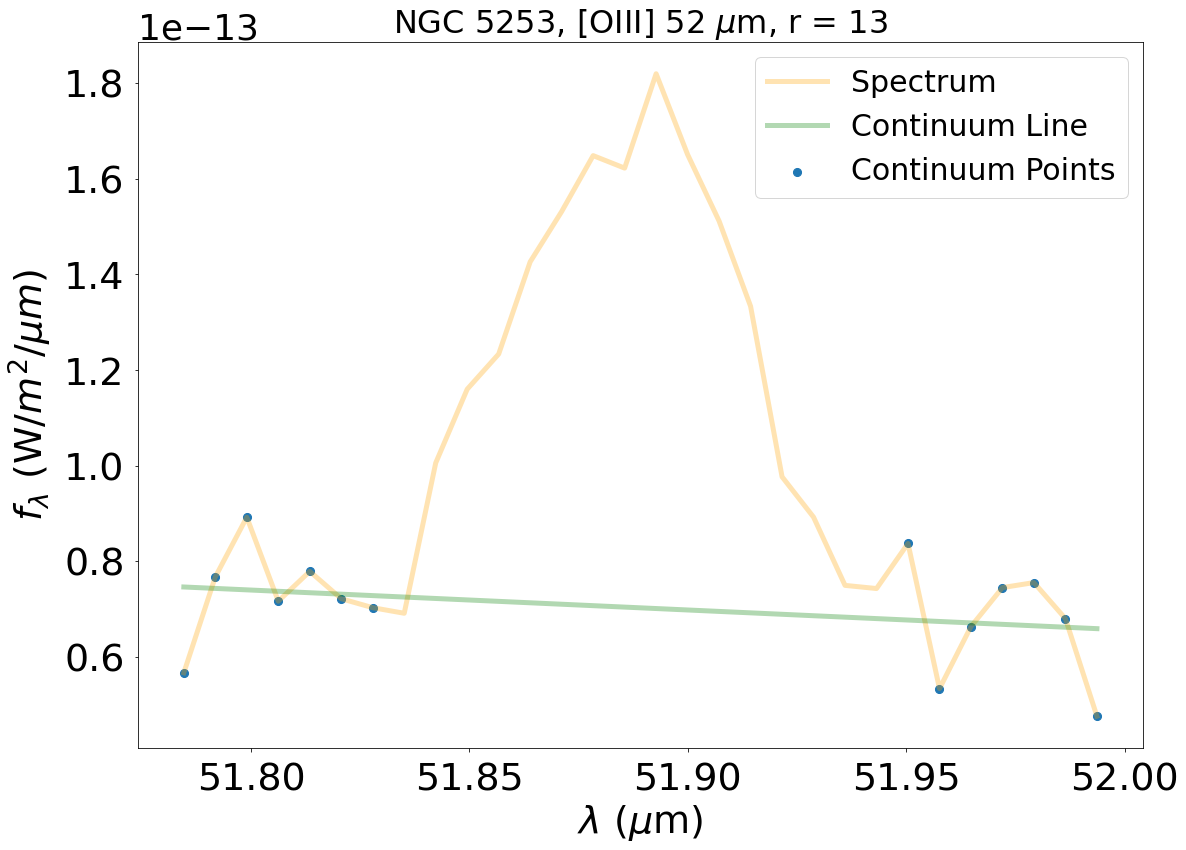

In [495]:
plot_filtered_spectrum_continuum_line(wavelengths_filtered, central_fluxes_filtered,
                                    central_fluxes_filtered_continuum, cont_params, titlename, filename, savedir)

In [496]:
wavelengths_act, central_fluxes_continuum_subtracted_act = subtract_continuum(central_fluxes_filtered_continuum, 
                                                                              cont_params, wavelengths_filtered, 
                                                                              central_fluxes_filtered)

In [497]:
fit_params = fit_gaussian(wavelengths_act, central_fluxes_continuum_subtracted_act)

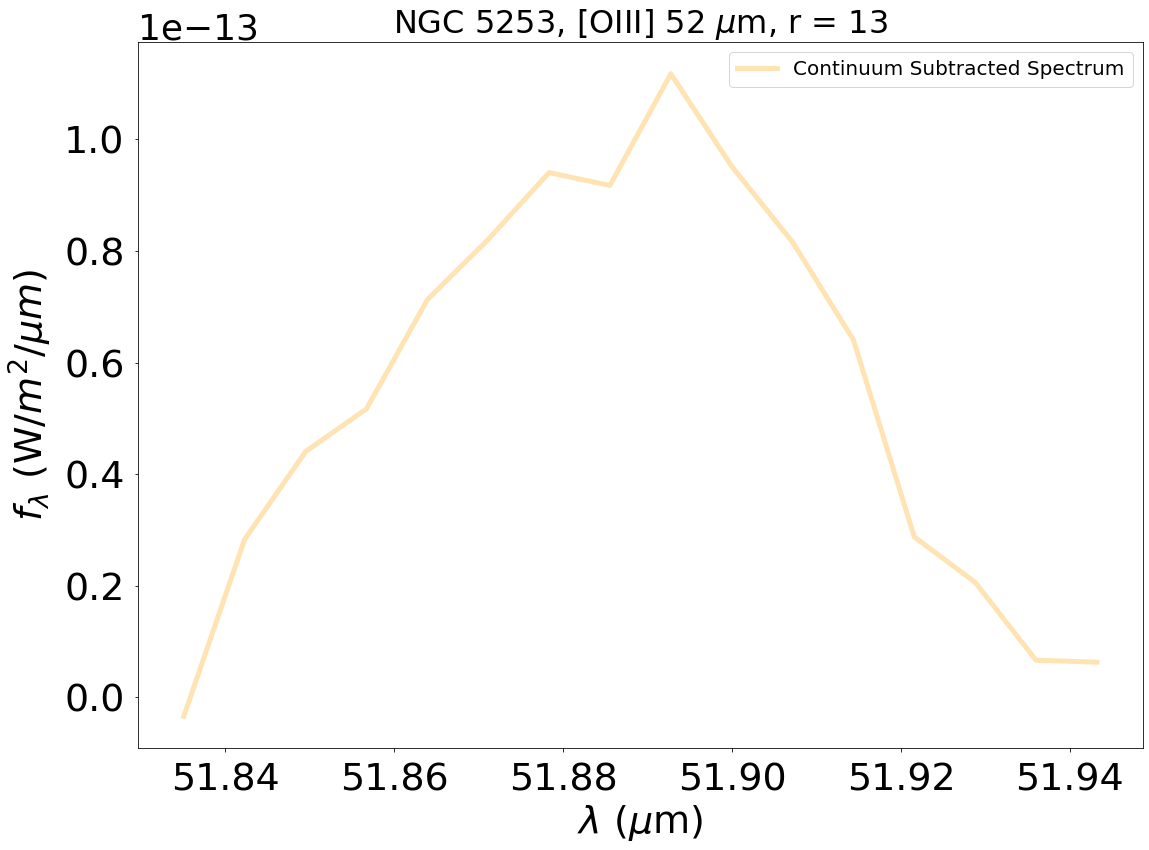

In [498]:
plot_continuum_subtracted_spectrum(wavelengths_act, central_fluxes_continuum_subtracted_act, titlename, filename, savedir)

In [499]:
wavelength_range, cont_line_filtered, fitted_central_fluxes_act = overlay(wavelengths_filtered, fit_params)

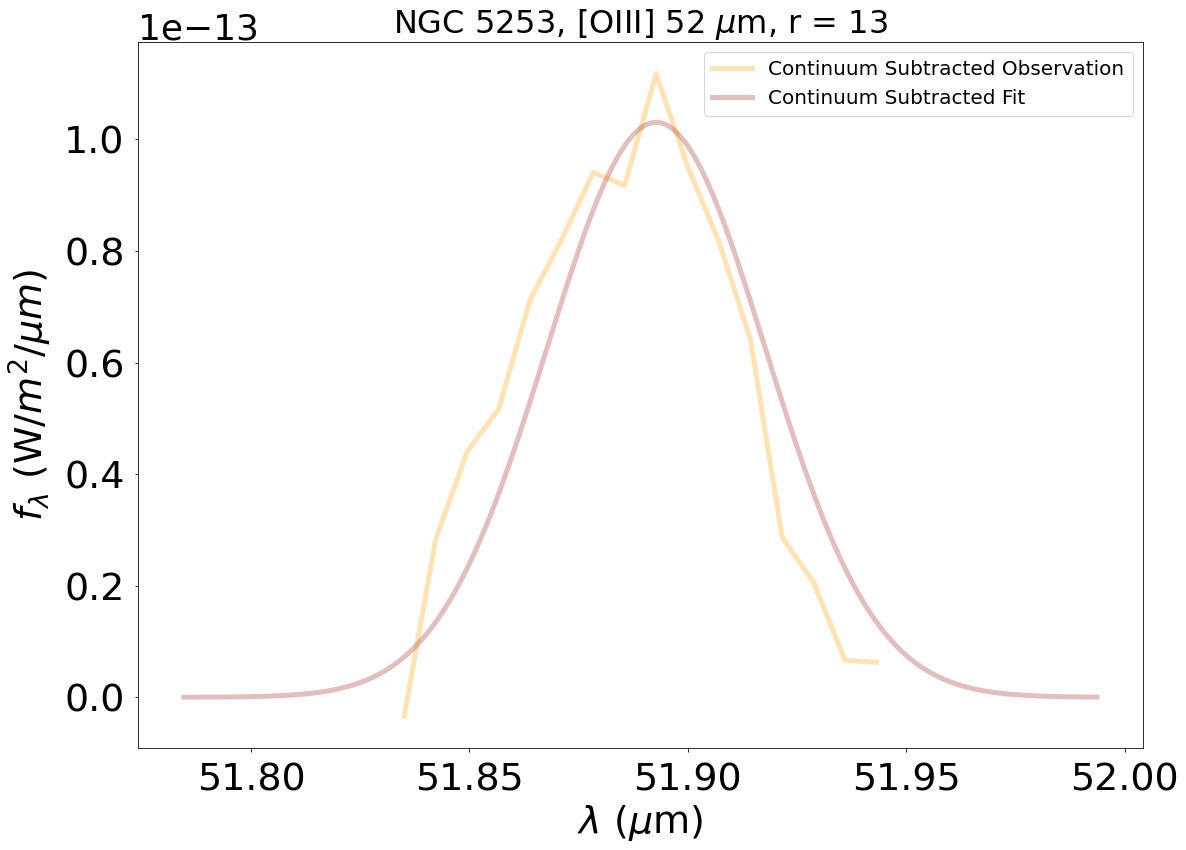

In [500]:
plot_fit_continuum_subtracted_spectrum(wavelengths_act, wavelength_range, fit_params, 
                                           central_fluxes_continuum_subtracted_act, titlename, filename, savedir)

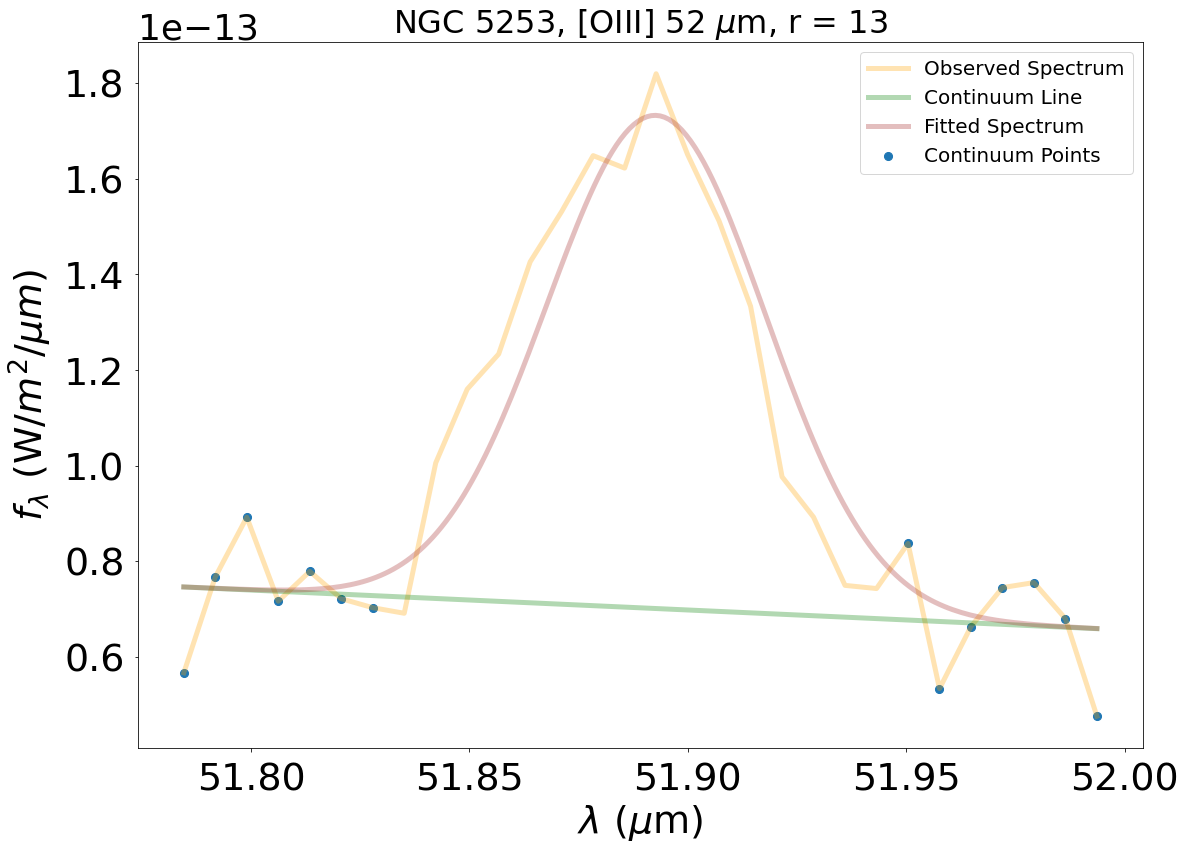

In [501]:
plot_final_spectrum(wavelengths_filtered, cont_params, fit_params, titlename, filename, savedir)

In [502]:
flux_continuum, flux_obs_sub, flux_fit_sub = compute_fluxes(wavelengths_filtered, wavelength_range, 
                                                            cont_line_filtered, central_fluxes_filtered, 
                                                            fitted_central_fluxes_act)

In [503]:
print(flux_continuum)
print(flux_obs_sub)
print(flux_fit_sub)

1.4689936136284844e-14
6.4343887161318105e-15
6.461710312269857e-15


In [504]:
f = open(savedir + filename + "_measurements.txt".format(str(r)), "w")
f.write('Flux of the continuum = ' + str(flux_continuum) + ' W/m^2 \n \n')
f.write('Flux of the observation = ' + str(flux_continuum + flux_obs_sub) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2 \n \n')
f.write('Flux of the fit = ' + str(flux_continuum + flux_fit_sub) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2 \n \n')
f.write('FWHM of fitted Gaussian = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')
f.close()